# Homework 4 

## 0. Loading the data

The data we will use is a simplified and reduced version of the [MNIST](http://yann.lecun.com/exdb/mnist/) set of handwritten digits, one of the most commonly-used data sets in machine learning. 

This version of the data was kindly provided by [Prof. Raj Rao](http://web.eecs.umich.edu/~rajnrao/), University of Michigan.

(i) Load the training data from [`training_digits.jld`](training_digits.jld) using the [`JLD.jl`](https://github.com/JuliaIO/JLD.jl) package, and explore it.

The data consists of a 3-dimensional array ("tensor"):

- The third component runs from 1 to 10, and specifies the digit from 0 to 9. 
- The columns $\mathbf{x}_i$ (the first component) are vectors of length $n=256$ representing grayscale images of $16 \times 16$ pixels. 
- The second component runs over the number of training examples.

In the same file are the corresponding labels $y_i \in \{0, \ldots, 9\} =: Y$.

Load the test data from [`test_digits.jld`](test_digits.jld).


In [1]:
import JLD

In [2]:
train = JLD.load("training_digits.jld")["TRAIN_DIGITS"];
test = JLD.load("test_digits.jld")

Dict{String,Any} with 2 entries:
  "labels" => [9.0 6.0 … 0.0 1.0]
  "digits" => [-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1…

(ii) Visualize some of the digits by reshaping them to a $16 \times 16$ array and plotting the resulting image, e.g. using `matshow` in PyPlot. Use e.g. `@manipulate`. Note that some of the data is all zero.

In [3]:
using Interact
using Plots
pyplot(leg=false, ticks=nothing, grid=false, border=false)

Plots.PyPlotBackend()

Interact.Slider{Int64}(Signal{Int64}(4, nactions=0),"digit",4,0:9,"d",true)

Interact.Slider{Int64}(Signal{Int64}(160, nactions=0),"idx",160,1:319,"d",true)


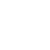

In [5]:
@manipulate for digit=0:9, idx=1:319
    heatmap(rotl90(reshape(train[:,idx,digit+1], 16, 16)),
            c=ColorGradient([:white, :black]),
            aspectratio=:equal, size=(50, 50))
end

In [474]:
good_idxs = Int[]
raw_digits = Int[]
for i in 1:3190
    digit = Int(floor((i-1)/319))
    idx = i - 319*digit
    if !all(train[:,idx,digit+1] .== 0)
        append!(good_idxs, i)
        append!(raw_digits, digit)
    end
end

digits = [d == digit+1 ? 1 : 0 for digit in raw_digits, d in 1:10];

In [6]:
@gif for i in good_idxs
    digit = Int(floor((i-1)/319))
    idx = i - 319*digit
    heatmap(rotl90(reshape(train[:,idx,digit+1], 16, 16)),
            c=ColorGradient([:white, :black]),
            aspectratio=:equal, size=(50, 50))
end every 10

INFO: Saved animation to /home/eburn/projects/18337/18.337_2016/homeworks/homework_4/tmp.gif


Plots.AnimatedGif("/home/eburn/projects/18337/18.337_2016/homeworks/homework_4/tmp.gif")

## 1. Least squares

One of the first ideas that we could have is to look for a simple function $f^{(i)}$  that classifies each digit as e.g. "being a 7 or not being a 7". We could thus look for a linear map (the simplest type of map) from $\mathbb{R}^n$ to $\mathbb{R}$ that maps $\mathbf{x}_i$ to a $1$ or $0$, depending if the image does or does not correspond to a digit of type $i$.

(iii) Express the "being a 7" problem as a matrix-vector multiplication over a single matrix containing all the data. Use least squares (`\`) to solve the problem.

`begin Ned`

$\mathsf{W} \mathbf{x} = \mathbf{y}$

size(W) = 10, 256

size(x) = 256, 1707

size(y) = 10, 1707

`end Ned`

In [562]:
A = Array{Float64,2}(1707, 256)

for i in 1:length(good_idxs)
    gidx = good_idxs[i]
    digit = Int(floor((gidx-1)/319))
    idx = gidx - 319*digit
    A[i,:] = train[:,idx,digit+1]
end

In [563]:
x = A'
y = digits'
W = y / x;

W' ≈ x' \ y'  # using backslash notation

true

(iv) Stacking up all such problems vertically gives a problem where the vector $\mathbf{x}_i$ is mapped onto a **one-hot vector** $\mathbf{y}_i$ representing the digit $y_i$. It turns out that some of the data vectors are all zero. Remove these and make one single matrix $\mathsf{x}$ by horizontally stacking the data, and another, $\mathsf{y}$ the corresponding one-hot vectors. 

Using least squares, find the matrix $\mathsf{W}$ that best solves $\mathsf{W} \mathbf{x}_i \approx \mathbf{y}_i$ for each $i$. (NB: Take care about the dimensions. What are you solving for?) 

Use the resulting matrix $\mathsf{W}$ to classify the test digits. What proportion does it get right?

In [9]:
y_raw = W*x;
y_hat = mapslices(indmax, y_raw, 1) - 1

incorrect_idxs = find(x -> x != 0, (y_hat - raw_digits'))
@printf("Got %.1f%% right in training set", 100*(1-length(incorrect_idxs)/length(y_hat)))

Got 96.2% right in training set

In [10]:
y_raw = W*test["digits"];
y_hat = mapslices(indmax, y_raw, 1) - 1

incorrect_idxs = find(x -> x != 0, (y_hat - test["labels"]))
@printf("Got %.1f%% right in testing set", 100*(1-length(incorrect_idxs)/length(y_hat)))

Got 84.5% right in testing set

In [11]:
sorted_incorrect_idxs = sort(incorrect_idxs, by= i->test["labels"][i])
@gif for idx in sorted_incorrect_idxs
    heatmap(rotl90(reshape(test["digits"][:,idx], 16, 16)),
            c=ColorGradient([:white, :black]),
            aspectratio=:equal, size=(50, 50))
end

INFO: Saved animation to /home/eburn/projects/18337/18.337_2016/homeworks/homework_4/tmp.gif


Plots.AnimatedGif("/home/eburn/projects/18337/18.337_2016/homeworks/homework_4/tmp.gif")

(v) Instead of just $\mathsf{W} \mathbf{x}_i = \mathbf{y}_i$, do the same with $\mathsf{W} \mathbf{x} + \mathbf{b} = \mathbf{y}_i$, by adding an extra $1$ at the bottom of each $\mathbf{x}_i$.

In [11]:
x_b = [x; ones(1, size(x, 2))]
W_b = y / x_b

y_raw = W_b*[test["digits"]; ones(1, size(test["digits"], 2))]
y_hat = mapslices(indmax, y_raw, 1) - 1

incorrect_idxs = find(x -> x != 0, (y_hat - test["labels"]))
@printf("Got %.1f%% right in testing set", 100*(1-length(incorrect_idxs)/length(y_hat)))

Got 84.5% right in testing set

`begin Ned`

Why does this make no difference? Perhaps because the corners tended to be -1.0 already, and so were useful as constant factors?

`end Ned`

(vi) Use `@manipulate` to scroll through misclassified images and discuss their features.

Interact.Slider{Int64}(Signal{Int64}(4, nactions=0),"i",4,0:9,"d",true)


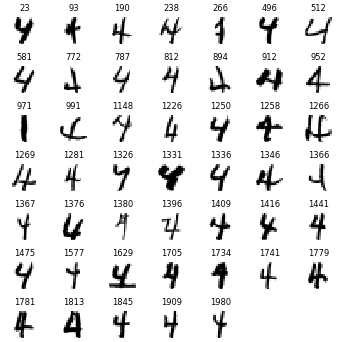

In [12]:
incorrect_by_label = [filter(i -> test["labels"][i] == j, incorrect_idxs) for j in 0:9]
tfont = Plots.Font("Arial", 6, :hcenter, :vcenter, 0.0, RGB(0,0,0))
@manipulate for i in 0:9
    plots = [heatmap(rotl90(reshape(test["digits"][:,idx], 16, 16)),
                     c=ColorGradient([:white, :black]),
                     aspectratio=:equal,
                     title=string(idx), titlefont=tfont)
             for idx in incorrect_by_label[i+1]]
    n = length(incorrect_by_label[i+1])
    plot(plots..., size=(50*sqrt(n), 50*sqrt(n)))
end

`begin Ned`

Misclassified numbers
---------------------

_#s refer to the index of that digit in the test dataset_

0: Pointy-topped and multiply-looped zeros! #995 is just a horizontal smear.

1: Long sloping top lines and other branches.

2: Big inner loops, along with some perfectly fine-looking 2s. #s 921, 1404, 1623 and 624 are vertically squashed.

3: Especially curly 3s. #1105 has no inner bump, it's just a backwards c.

4: #971 looks more like a 1 to me. Otherwise they're mostly open-top fours.

5: #994 is definitely a zero, and #1978 a 3. Weak definition of the upper story and thick lines seem to be common.

6: #699 looks like a 4 to me. The others lean left or have little to no inner white space.

7: Sevens with a strongly defined "hook" on the edge of the horizontal line. #1529 looks like a ']'

8: #s 1653 and 199 are clipped by the image extents! Otherwise these just seem a bit asymmetric.

9: #109 is clipped, and #1865 looks like an o on top of a w. Otherwise these seem either thick or rotated to the right.

`end Ned`

## 2. SVD

(vii) To get a feel for the SVD, decompose your favorite image using it, following the instructions in the [SVD for images](SVD for images.ipynb) notebook.

An approach to the learning problem via the SVD is as follows.

(viii) For each set of training data (i.e. for the data corresponding to a given digit), take the SVD of the data and use it to approximate the data by a rank-$k$ hyperplane through the origin, i.e. to find the closest hyperplane of dimension $k$ passing through the data.

Classify the test digits by finding to which of these hyperplanes it is closest, using a suitable **projection matrix**.
How well does this classification method do on the test data? How does this depend on $k$?

In [279]:
k = 3

function make_dist_fn(d, k)
    A_d = hcat(filter(A -> !all(A .== 0), [train[:,i,d] for i in 1:319])...)
    u, s, v = svd(A_d)
    return img -> norm(u[:,1:k]'*img)
end


dist_fns = [make_dist_fn(d, k) for d=1:10]

y_hat = []
for i in 1:length(good_idxs)
    gidx = good_idxs[i]
    digit = Int(floor((gidx-1)/319))
    idx = gidx - 319*digit
    img = train[:,idx,digit+1]
    results = [fn(img) for fn in dist_fns]
    append!(y_hat, [indmax(results) - 1])
end

incorrect_idxs = find(x -> x != 0, (y_hat - raw_digits))
@printf("Got %.1f%% right in training set", 100*(1-length(incorrect_idxs)/length(y_hat)))

Got 94.3% right in training set

`begin Ned`

`u[:,1:k]` are the k basis vectors of the hyperplane, selected from the columns of u.

Very unclear why the above works when I'm taking the *max* distance...must have made a sign error somewhere?

`end Ned`

In [268]:
k = 1

function incorrect_ratio(k)
    dist_fns = [make_dist_fn(d, k) for d=1:10]

    n = size(test["digits"], 2)
    y_hat = Array{Int,1}(n)

    for i=1:n
        img = test["digits"][:,i]
        results = [fn(img) for fn in dist_fns]
        y_hat[i] = indmax(results) - 1
    end

    incorrect_idxs = find(x -> x != 0, (y_hat' - test["labels"]))
#     @printf("Got %.1f%% right in training set", 100*(1-length(incorrect_idxs)/length(y_hat)))
    1 - length(incorrect_idxs)/length(y_hat)
end

data = incorrect_ratio.(1:60)

60-element Array{Float64,1}:
 0.801694
 0.86298 
 0.878924
 0.899851
 0.90284 
 0.905331
 0.916791
 0.920279
 0.926258
 0.931739
 0.932237
 0.935725
 0.936223
 ⋮       
 0.922272
 0.920777
 0.918286
 0.918784
 0.919283
 0.919781
 0.919283
 0.918784
 0.919283
 0.920777
 0.920279
 0.920279


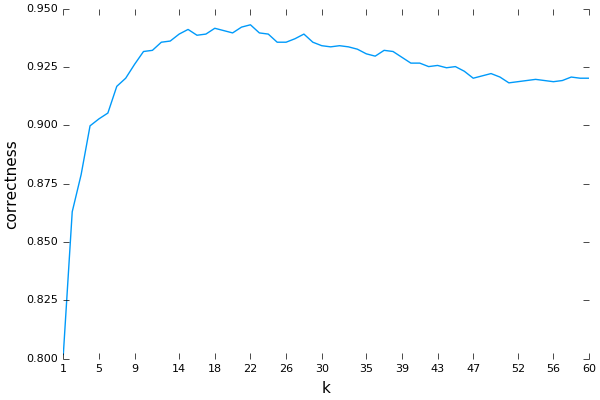

In [275]:
plot(data)
xlabel!("k")
ylabel!("correctness")
ylims!(0.8, 0.95)
xticks!(1:60)
yticks!(0.8:0.025:1)

`begin Ned`

As you'd expect, there's an optimal value for k before overfitting begins.

Note that you can get 80% accuracy with an "eigen-digit" approach (k=1)

`end Ned`

## 3. Stochastic gradient descent

Now we will repeat the least-squares calculation, but using a technique that generalizes to (much) more complicated scenarios: **stochastic gradient descent**.

We wish to minimise the least-squares cost function $C := \sum_i C_i$, where $C_i(x) := \|\mathsf{W} \mathbf{x}_i - \mathbf{y}_i \|^2$, using gradient descent. However, the function depends on many variables (all the $\mathbf{x}_i$), so calculating its gradient is very expensive.

In stochastic gradient descent, we instead choose a single, random $i$ and update the matrix $\mathsf{W}$ by using gradient descent with respect to $C_i$ only, where we think of $C_i$ as a function of $\mathsf{W}$. 

The difficult part about using gradient descent is usually calculating and evaluating these gradients; in general, we use reverse automatic differentiation (called **backpropagation** in the neural networks community). However, in this particular example, the gradient is simple enough to calculate by hand.

(ix) Show that the gradient of $f(\mathbf{x}) := \| \mathsf{W} \mathbf{x} - \mathbf{y} \|^2$ with respect to the matrix $\mathsf{W}$ is $2 \, (\mathsf{W} \mathbf{x} - \mathbf{y}) \, \mathbf{x}^\mathrm{T}$. 

`begin Ned`

$ f(\mathbf{x}) = \sum_i (\mathbf{W_i}\mathbf{x})^2 - 2 \mathbf{W_i}\mathbf{x} y_i + y_i^2$

$ f(\mathbf{x}) = \sum_i (\mathbf{W_i}\mathbf{x} - 2 y_i)\mathbf{W_i}\mathbf{x} + y_i^2$

$ f(\mathbf{x}) = \sum_i (\sum_j W_{ij}x_j)^2 - 2 y_i \sum_jW_{ij}x_j+ y_i^2$

$ \frac{d(f(\mathbf{x}))}{d W_{ij}} = 2 W_{ij} x_j^2 - 2 y_i x_j = 2 (W_{ij} x_j - y_i) x_j$

The parentheses handle index i, and so will return a length(y) x 1 vector; times $\mathbf{x}^\mathrm{T}$ this will yield our length(y) x length(x) matrix:

$ \frac{d(f(\mathbf{x}))}{d \mathsf{W}} = 2 (\mathsf{W}\mathbf{x} - \mathbf{y}) \, \mathbf{x}^\mathrm{T}$

`end Ned`

(x) Use this to do stochastic gradient descent with a step size of $\eta = 0.001$, choosing one $i$ randomly at each step and moving in the direction that minimises $C_i$. 

After each 1000 steps, calculate the proportion of test cases that are correctly classified and draw this as a function of number of steps. How many steps are required to get close to the optimal solution, given by the linear algebra result in section 1? How well does the classification do compared to that?


In [570]:
W_sgd = zeros(10, 256)

η = 0.001

for i=1:1000000
    idx = rand(1:length(good_idxs))
    y = digits[idx,:]
    gidx = good_idxs[idx]
    digit = Int(floor((gidx-1)/319))
    tidx = gidx - 319*digit
    x = train[:,tidx,digit+1]
    
    dW = 2*(W_sgd*x - y)*x'
    W_sgd = W_sgd - η*dW
end

y_raw = W_sgd*test["digits"]
y_hat = mapslices(indmax, y_raw, 1) - 1

incorrect_idxs = find(x -> x != 0, (y_hat - test["labels"]))
@printf("Got %.1f%% right in testing set", 100*(1-length(incorrect_idxs)/length(y_hat)))

norm(W_sgd - W)

Got 82.9% right in testing set

0.2186091250078466

`begin Ned`

It only seems to take ~3000 steps to get close to the optimal solution's classification quality, but the norm seems to stay pretty far away even with a 100 times as many steps?

`end Ned`